# Build Regression Model To Predict Forward Return. 

In [1]:
# Python module. 
import re, os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import xgboost as xgb
import shap, optuna 
from optuna import visualization as opt_viz 
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import ElasticNet 
from sklearn.metrics import mean_squared_error 

# Change the current directory from (./notebook) to root directory. 
while not re.match(r".+MADS-CAP$", os.getcwd()): 
	os.chdir("..") 
	
print(f"Current directory: ({os.getcwd()})") 

# For clearing safe warnings. Not important. 
from IPython.display import clear_output

# Custom modules. 
from source.modules.manage_files import ManageFiles 
from source.modules.processor_estim import ColumnSelector, multiverse_analysis 
from source.modules import visualizer 

# Custom configs. 
from source.config_py.config import (
	DIR_DATASET_CONSOLIDATED, DIR_MLMODEL_MLESTIM, 
	DIR_MLMODEL_MLPERFORMANCE, PARAM_SEED, 
) 

/Users/lioneltay/.local/share/virtualenvs/MADS-CAP-gLyVeGLS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current directory: (/Users/lioneltay/Dropbox/Courses/michigan_mads/SIADS_697_/submission/MADS-CAP)


## Configurations (general). 

In [2]:
# Matplotlib setting. 
%matplotlib inline 

# Pandas DF config. 
pd.set_option("display.max_rows", 50, "display.max_columns", 100, "display.max_colwidth", 50)

# File management setup. 
manage_files = ManageFiles() 

# Ensure reproducibility. 
np.random.seed(PARAM_SEED) 

# Define ticker. 
ticker = "AAPL" 

# Define the features and target variable. 
ret_lag = 5 
targcol = f"return_c2c_lag{ret_lag}" 

# For clearing the output. Not important. 
clear_output()

## Load consolidated ticker data. 

In [3]:
filepath = os.path.join(DIR_DATASET_CONSOLIDATED, "consolidated_feature.parquet")
df_feature = pd.read_parquet(filepath) 

# Preview. 
df_feature 

,date,open,high,low,close,volume,dividends,stock_splits,ticker,return_c2c_lag1,tscore_c2c_lag1,return_c2c_lag5,tscore_c2c_lag5,return_c2c_lag10,tscore_c2c_lag10,return_c2c_lag21,tscore_c2c_lag21,return_c2c_lag126,tscore_c2c_lag126,return_c2c_lag252,tscore_c2c_lag252,vix_date,vix_open,vix_close,jobs_opening_labor_turnover,non_farm_employment_adp_mom,non_farm_employment_mom,unemployment_claims,unemployment_rate,avg_hourly_earnings_mom,personal_dispensable_income_mom,personal_consumption_mom,ism_pmi_manufacturer,ism_pmi_services,chicago_pmi,industry_production_mom,phil_fed_manufacturer,capacity_utilisation,manufacturer_new_order_mom,manufacturer_new_order_ex_trans_mom,retail_sales_ex_auto_mom,retail_sales_mom,uom_consumer_sentiment,producer_ppi_mom,producer_ppi_ex_food_energy_mom,consumer_cpi_mom,consumer_cpi_ex_food_energy_mom,pce_ex_food_energy_mom,housing_hpi_mom,housing_hpi_cs_yoy,...,econ_bond_yield_3mo,econ_bond_yield_5yr,econ_consumer_confidence_oecd,econ_consumer_sentiment_umich,econ_fed_ffr,econ_mortgage_rate_15yr,econ_mortgage_rate_30yr,econ_prime_loan_rate,rp_ticker,rp_date,rp_relevance,rp_ess,rp_aes,rp_aev,rp_ens,rp_ens_similarity_gap,rp_css,rp_nip,rp_peq,rp_bee,rp_bmq,rp_bam,rp_bca,rp_ber,rp_anl_chg,rp_mcq,techind_ticker,techind_date,techind_macd_MACD_Hist,techind_macd_MACD,techind_macd_MACD_Signal,techind_stoch_SlowK,techind_stoch_SlowD,cdl3blackcrows,cdldarkcloudcover,cdldoji,cdldojistar,cdldragonflydoji,cdlengulfing,cdleveningdojistar,cdleveningstar,cdlhammer,cdlhangingman,cdlharami,cdlinvertedhammer,cdlmorningdojistar,cdlmorningstar,cdlrickshawman,cdlshootingstar,cdltristar
0,1998-11-30,154.66,154.84,147.12,147.85,2063440.0,0.0,0.0,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-11-30,22.79,26.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1998-12-01,143.44,147.49,141.42,147.12,2291020.0,0.0,0.0,C,-0.004937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-12-01,27.38,24.97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4.49,4.43,101.978479,100.5,4.68,6.39,6.74,7.75,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,1998-12-01,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1998-12-02,146.02,150.61,145.28,148.04,1852540.0,0.0,0.0,C,0.006253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-12-02,25.63,25.43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4.48,4.31,101.978479,100.5,4.68,6.39,6.74,7.75,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,1998-12-02,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1998-12-03,146.93,147.12,141.23,141.79,2681740.0,0.0,0.0,C,-0.042218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-12-03,25.53,28.70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4.45,4.31,101.978479,100.5,4.68,6.39,6.74,7.75,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,1998-12-03,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1998-12-04,144.54,146.02,140.50,145.83,2304760.0,0.0,0.0,C,0.028493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-12-04,26.28,25.31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4.48,4.38,101.978479,100.5,4.68,6.39,6.74,7.75,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,1998-12-04,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174254,2022-02-18,149.69,151.66,148.70,149.70,11733300.0,0.0,0.0,JPM,0.004698,0.539537,-0.002

## Preprocess ticker data. 

### Visualize the label distribution. 

Text(0.5, 1.0, 'return_c2c_lag5')

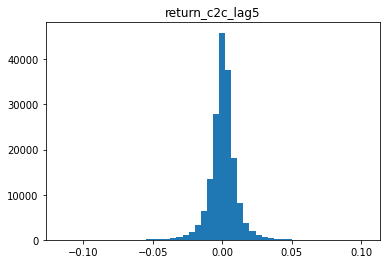

In [4]:
plt.hist(x=df_feature[targcol], bins=50) 
plt.title(targcol) 

### Preprocessing steps go here... 

In [5]:
# Filter by ticker. 
boo_ticker = df_feature["ticker"] == ticker 

# Filter by date. 
df_feature["date"] = pd.to_datetime(df_feature["date"], infer_datetime_format=True) 
boo_date = df_feature["date"].dt.year >= 2010 

# Filter. 
df_feature_fil = df_feature[boo_ticker & boo_date].copy() 

# Preview. 
df_feature_fil

,date,open,high,low,close,volume,dividends,stock_splits,ticker,return_c2c_lag1,tscore_c2c_lag1,return_c2c_lag5,tscore_c2c_lag5,return_c2c_lag10,tscore_c2c_lag10,return_c2c_lag21,tscore_c2c_lag21,return_c2c_lag126,tscore_c2c_lag126,return_c2c_lag252,tscore_c2c_lag252,vix_date,vix_open,vix_close,jobs_opening_labor_turnover,non_farm_employment_adp_mom,non_farm_employment_mom,unemployment_claims,unemployment_rate,avg_hourly_earnings_mom,personal_dispensable_income_mom,personal_consumption_mom,ism_pmi_manufacturer,ism_pmi_services,chicago_pmi,industry_production_mom,phil_fed_manufacturer,capacity_utilisation,manufacturer_new_order_mom,manufacturer_new_order_ex_trans_mom,retail_sales_ex_auto_mom,retail_sales_mom,uom_consumer_sentiment,producer_ppi_mom,producer_ppi_ex_food_energy_mom,consumer_cpi_mom,consumer_cpi_ex_food_energy_mom,pce_ex_food_energy_mom,housing_hpi_mom,housing_hpi_cs_yoy,...,econ_bond_yield_3mo,econ_bond_yield_5yr,econ_consumer_confidence_oecd,econ_consumer_sentiment_umich,econ_fed_ffr,econ_mortgage_rate_15yr,econ_mortgage_rate_30yr,econ_prime_loan_rate,rp_ticker,rp_date,rp_relevance,rp_ess,rp_aes,rp_aev,rp_ens,rp_ens_similarity_gap,rp_css,rp_nip,rp_peq,rp_bee,rp_bmq,rp_bam,rp_bca,rp_ber,rp_anl_chg,rp_mcq,techind_ticker,techind_date,techind_macd_MACD_Hist,techind_macd_MACD,techind_macd_MACD_Signal,techind_stoch_SlowK,techind_stoch_SlowD,cdl3blackcrows,cdldarkcloudcover,cdldoji,cdldojistar,cdldragonflydoji,cdlengulfing,cdleveningdojistar,cdleveningstar,cdlhammer,cdlhangingman,cdlharami,cdlinvertedhammer,cdlmorningdojistar,cdlmorningstar,cdlrickshawman,cdlshootingstar,cdltristar
141955,2010-01-04,6.52,6.55,6.49,6.54,493729600.0,0.0,0.0,AAPL,0.017107,0.570544,0.004966,0.272474,0.011039,1.068657,0.004192,0.401688,0.003464,0.390206,0.003415,1.200618,2010-01-04,21.68,20.04,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.08,2.65,98.299637,74.4,0.11,4.44,5.03,3.25,AAPL,2010-01-04,100.0,67.0,57.0,77.0,100.0,27.42061,50.0,45.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,AAPL,2010-01-04,0.0543,0.1199,0.0656,81.3819,78.0429,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
141956,2010-01-05,6.55,6.58,6.51,6.55,601904800.0,0.0,0.0,AAPL,0.001529,0.000211,0.002771,0.111603,0.009315,0.876671,0.004185,0.404235,0.003667,0.499379,0.003252,0.947847,2010-01-05,20.05,19.35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.07,2.56,98.299637,74.4,0.11,4.44,5.03,3.25,AAPL,2010-01-05,100.0,67.0,58.0,82.0,100.0,100.00000,52.0,45.0,50.0,50.0,100.0,50.0,50.0,50.0,50.0,100.0,AAPL,2010-01-05,0.0523,0.1309,0.0787,81.7015,78.8435,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
141957,2010-01-06,6.55,6.57,6.44,6.44,552160000.0,0.0,0.0,AAPL,-0.016794,-0.671146,0.001560,0.021939,0.006267,0.540678,0.004179,0.405741,0.003417,0.371277,0.003254,0.948892,2010-01-06,19.59,19.16,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.06,2.60,98.299637,74.4,0.11,4.44,5.03,3.25,AAPL,2010-01-06,100.0,40.0,56.0,81.0,100.0,33.95867,47.0,36.0,50.0,50.0,0.0,50.0,50.0,50.0,50.0,0.0,AAPL,2010-01-06,0.0409,0.1298,0.0889,70.6672,77.9169,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
141958,2010-01-07,6.47,6.47,6.38,6.43,477131200.0,0.0,0.0,AAPL,-0.001553,-0.120201,-0.000931,-0.167130,0.004953,0.397378,0.005171,0.560573,0.003462,0.397469,0.003333,1.066306,2010-01-07,19.68,19.06,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.05,2.62,98.299637,74.4,0.11,4.44,5.03,3.25,AAPL,2010-01-07,100.0,64.0,56.0,82.0,100.0,97.03524,50.0,34.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,AAPL,2010-01-07,0.0300,0.1264,0.0964,47.7707,66.7131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
141959,2010-01-08,6.42,6.47,6.38,6.47,447610800.0,0.0,0.0,AAPL,0.006221,0.151040,0.001241,-0.012221,0.004759,0.374029,0.005219,0.566727,0.003379,0.357262,0.003287,0.996466,2010-01-08,19.27,18.13,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.05,2.57,98.299637,74.4,0.11,4.44,5.03,3.25,AAPL,2010-01-08,100.0,67.0,56.0,82.0,100.0,3.00000,50.0,45.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,AAPL,2010-01-08,0.0235,0.1258,0.1023,34.9114,

## Develop models. 

### Split train test. 

In [6]:
# Get all the target variables (at different lag). 
targetcols = [c for c in df_feature.columns if re.match(r"\w+_c2c_lag\d{1,4}$", c)] 

# # Uncomment this to use this to explore all independant variables. 
usecols = df_feature.columns.difference(targetcols) 

# Define the training and label dataset. 
X, y = df_feature_fil.loc[:, usecols], df_feature_fil.loc[:, targcol] 
print("SHAPE:", X.shape) 

# Train test split. 
train_size = .8 
split_frm = int(X.shape[0] * train_size) 
X_train, y_train = X.iloc[:split_frm], y.iloc[:split_frm] 
X_test, y_test = X.iloc[split_frm:], y.iloc[split_frm:] 
print("SHAPE:", X_train.shape) 
print("SHAPE:", X_test.shape) 

# For storing all the k-fold splits for cross-validation during model training. 
timeseries_cv = [] 

# Perform the k-fold splits. 
timeseries_split = TimeSeriesSplit(n_splits=10) 

for train_index, test_index in timeseries_split.split(X_train): 
	timeseries_cv.append((train_index, test_index)) 
	print("TRAIN:", len(train_index), "| TEST:", len(test_index)) 

SHAPE: (3059, 128)
SHAPE: (2447, 128)
SHAPE: (612, 128)
TRAIN: 227 | TEST: 222
TRAIN: 449 | TEST: 222
TRAIN: 671 | TEST: 222
TRAIN: 893 | TEST: 222
TRAIN: 1115 | TEST: 222
TRAIN: 1337 | TEST: 222
TRAIN: 1559 | TEST: 222
TRAIN: 1781 | TEST: 222
TRAIN: 2003 | TEST: 222
TRAIN: 2225 | TEST: 222


### Multiverse Analysis. 

In [7]:
# Use this explore selected independant variables. 
use_features = [
	{
		"econometric": [
			"econ_bond_yield_10yr",
			"econ_bond_yield_10yr_minus_2yr",
			"econ_bond_yield_10yr_minus_3mo",
			"econ_bond_yield_10yr_minus_ffr",
			"econ_bond_yield_2yr",
			"econ_bond_yield_30yr",
			"econ_bond_yield_3mo",
			"econ_bond_yield_5yr",
			"econ_consumer_confidence_oecd",
			"econ_consumer_sentiment_umich",
			"econ_fed_ffr",
			"econ_mortgage_rate_15yr",
			"econ_mortgage_rate_30yr",
			"econ_prime_loan_rate",
		] 
	},
]

In [8]:
# Uncomment this part if you want to rerun the multiverse analysis. 
# Take about 90 minutes to run 50 trials. 50 minutes for 25 trials. 
# SearchCV will automatically stops running the trial if the 
# optimisation reaches a plateau. 

# Perform multiverse analysis. 
df_performances = multiverse_analysis(
	X_train, y_train, cv=timeseries_cv, experiment_comps=use_features, n_trials=25, verbose=0
) 

# The scoring method is negative RMSE so we need to "absolute" it. 
df_performances["rmse_avg"] = df_performances["rmse_avg"].abs() 
df_performances = df_performances.sort_values(["rmse_avg", "rmse_std"], ascending=False, ignore_index=True) 

# Compute the interval range. 
df_performances["rmse_intv0025"] = df_performances["rmse_avg"] - (df_performances["rmse_std"] * 2) 
df_performances["rmse_intv0975"] = df_performances["rmse_avg"] + (df_performances["rmse_std"] * 2) 

# Preview. 
df_performances 

,est_names,estimator,component,rmse_avg,rmse_std,ml_n_comp,feat_name,rmse_intv0025,rmse_intv0975
0,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...","{'econometric': ['econ_bond_yield_10yr', 'econ...",0.015722,0.002770,"xgb + {'econometric': ['econ_bond_yield_10yr',...","[econ_bond_yield_10yr, econ_bond_yield_10yr_mi...",0.010182,0.021263
1,rfr,"XGBRFRegressor(base_score=0.5, booster='gbtree...","{'econometric': ['econ_bond_yield_10yr', 'econ...",0.008008,0.002094,"rfr + {'econometric': ['econ_bond_yield_10yr',...","[econ_bond_yield_10yr, econ_bond_yield_10yr_mi...",0.003820,0.012196
2,els,"ElasticNet(alpha=1, max_iter=5000, random_stat...","{'econometric': ['econ_bond_yield_10yr', 'econ...",0.007161,0.001169,"els + {'econometric': ['econ_bond_yield_10yr',...","[econ_bond_yield_10yr, econ_bond_yield_10yr_mi...",0.004823,0.009500


In [9]:
# Save the regression model performance record. 
manage_files.save_cache_pk(df_performances, dirpath=DIR_MLMODEL_MLPERFORMANCE, filename="regression_performance.pickle") 

# Load the past regression model performance record. 
df_performances = manage_files.load_cache_pk(dirpath=DIR_MLMODEL_MLPERFORMANCE, filename="regression_performance.pickle") 

# Preview. 
df_performances 

Save to (regression_performance.pickle)
Load from (regression_performance.pickle)


,est_names,estimator,component,rmse_avg,rmse_std,ml_n_comp,feat_name,rmse_intv0025,rmse_intv0975
0,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...","{'econometric': ['econ_bond_yield_10yr', 'econ...",0.015722,0.002770,"xgb + {'econometric': ['econ_bond_yield_10yr',...","[econ_bond_yield_10yr, econ_bond_yield_10yr_mi...",0.010182,0.021263
1,rfr,"XGBRFRegressor(base_score=0.5, booster='gbtree...","{'econometric': ['econ_bond_yield_10yr', 'econ...",0.008008,0.002094,"rfr + {'econometric': ['econ_bond_yield_10yr',...","[econ_bond_yield_10yr, econ_bond_yield_10yr_mi...",0.003820,0.012196
2,els,"ElasticNet(alpha=1, max_iter=5000, random_stat...","{'econometric': ['econ_bond_yield_10yr', 'econ...",0.007161,0.001169,"els + {'econometric': ['econ_bond_yield_10yr',...","[econ_bond_yield_10yr, econ_bond_yield_10yr_mi...",0.004823,0.009500


In [10]:
usecols = ["rmse_avg", "ml_n_comp", "rmse_intv0025", "rmse_intv0975"] 
visualizer.plot_multiverse_analysis(df_performances[usecols], x="rmse_avg", y="ml_n_comp", err_minmax=("rmse_intv0025", "rmse_intv0975")) 

alt.LayerChart(...)

### Rebuild the model selecting the approach. 

In [19]:
index = 1 

# Get the feature from the top performing model. 
usecols = df_performances.loc[index, "feat_name"] 

# Get the best estimator. 
estimator = df_performances.loc[index, "estimator"] 

# Model pipeline setup. 
mlpipe_estim = Pipeline([
	("select_col", ColumnSelector(var_proc=usecols)), 
]) 

X_train_feature = mlpipe_estim.fit_transform(X_train) 

# Clear safe warnings. Not important. 
clear_output() 

# Convert to dataframe. 
df_features = pd.DataFrame(X_train_feature, columns=mlpipe_estim["select_col"].get_feature_names_out()) 

# Preview. 
df_features 

,econ_bond_yield_10yr,econ_bond_yield_10yr_minus_2yr,econ_bond_yield_10yr_minus_3mo,econ_bond_yield_10yr_minus_ffr,econ_bond_yield_2yr,econ_bond_yield_30yr,econ_bond_yield_3mo,econ_bond_yield_5yr,econ_consumer_confidence_oecd,econ_consumer_sentiment_umich,econ_fed_ffr,econ_mortgage_rate_15yr,econ_mortgage_rate_30yr,econ_prime_loan_rate
141955,3.85,2.76,3.77,3.73,1.09,4.65,0.08,2.65,98.299637,74.4,0.11,4.44,5.03,3.25
141956,3.77,2.76,3.70,3.65,1.01,4.59,0.07,2.56,98.299637,74.4,0.11,4.44,5.03,3.25
141957,3.85,2.84,3.79,3.73,1.01,4.70,0.06,2.60,98.299637,74.4,0.11,4.44,5.03,3.25
141958,3.85,2.82,3.80,3.75,1.03,4.69,0.05,2.62,98.299637,74.4,0.11,4.44,5.03,3.25
141959,3.83,2.87,3.78,3.72,0.96,4.70,0.05,2.57,98.299637,74.4,0.11,4.44,5.03,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144397,1.81,0.09,-0.18,-0.49,1.72,2.27,1.99,1.66,100.902389,93.2,2.04,3.12,3.61,5.15
144398,1.80,0.03,-0.15,-0.45,1.77,2.25,1.95,1.68,100.902389,93.2,2.04,3.12,3.61,5.15
144399,1.79,0.05,-0.14,-0.11,1.74,2.22,1.93,1.66,100.902389,93.2,2.04,3.12,3.61,5.15
144400,1.74,0.05,-0.17,-0.16,1.69,2.17,1.91,1.61,100.902389,93.2,2.04,3.12,3.61,5.15


In [20]:
# # Uncomment this part if you wanna use this. 

# # Elastic Net. We assume to have many low coefficient features, so 
# # L2 penalty would be more appropriate for regularization in out case 
# # if it is needed. 
# estimator_els = ElasticNet(alpha=1, l1_ratio=.5, max_iter=5000, random_state=PARAM_SEED) 

# # Hyperparameter optimisation setup. 
# param_dist = {
#     "l1_ratio"  : [.5, .3, .1], 
# } 

# searchres = search_opt(estimator_els, X_train_feature, y_train, param_dist, bayes=False, n_trials=100, verbose=0) 

In [21]:
# # Uncomment this part if you wanna use this. 

# '''
# Documentation and tutorials: 
#     - https://xgboost.readthedocs.io/en/latest/parameter.html 
# ''' 

# # XGBoost. 
# estimator_xgb = xgb.XGBRegressor(
# 	learning_rate=0.001, n_estimators=100, max_depth=8, base_score=0.5, 
#     reg_lambda=0.1, reg_alpha=1.0, min_split_loss=0.05, min_child_weight=1, 
#     subsample=0.5, tree_method="auto", booster="gbtree", num_parallel_tree=2, 
#     objective="reg:squarederror", eval_metric="rmse", seed=PARAM_SEED, 
# ) 

# # Hyperparameter optimisation setup. 
# param_dist = {
#     "learning_rate"     : optuna.distributions.LogUniformDistribution(1e-4, 1e-2), 
#     "max_depth"         : optuna.distributions.IntUniformDistribution(3, 8), 
#     "n_estimators"      : optuna.distributions.IntUniformDistribution(100, 500), 
#     "min_child_weight"  : optuna.distributions.IntUniformDistribution(1, 20), 
# }

# searchres = search_opt(estimator_xgb, X_train_feature, y_train, param_dist, n_trials=50, verbose=0) 

In [22]:
# # Uncomment this part if you wanna use this. 

# '''
# Documentation and tutorials: 
#     - https://xgboost.readthedocs.io/en/stable/tutorials/rf.html 
# ''' 

# # Standalone Random Forest API. 
# estimator_rfr = xgb.XGBRFRegressor(
# 	learning_rate=1, n_estimators=100, max_depth=8, base_score=0.5, 
#     colsample_bynode=.5, reg_lambda=0.1, reg_alpha=1.0, min_split_loss=0.05,
#     min_child_weight=1, subsample=0.5, tree_method="auto", booster="gbtree", 
#     num_parallel_tree=2, objective="reg:squarederror", eval_metric="rmse", 
#     seed=PARAM_SEED, 
# ) 

# # Hyperparameter optimisation setup. 
# param_dist = {
#     "max_depth"         : optuna.distributions.IntUniformDistribution(3, 8), 
#     "n_estimators"      : optuna.distributions.IntUniformDistribution(100, 500), 
#     "min_child_weight"  : optuna.distributions.IntUniformDistribution(1, 20), 
# }

# searchres = search_opt(estimator_rfr, X_train_feature, y_train, param_dist, n_trials=1, verbose=0) 

### Model evaluation. 

In [23]:
# # Assign the best estimator if you retrain the model again. 
# estimator = searchres.best_estimator_ 

# Make prediction. 
base_score = y_train.mean() 
predicted = estimator.predict(X_train_feature) 

# Compare the prediction score. 
base_rmse = np.sqrt( mean_squared_error(y_train, [base_score] * len(y_train), squared=True) ) 
pred_rmse = np.sqrt( mean_squared_error(y_train, predicted, squared=True) ) 

print("Base RMSE: ", base_rmse) 
print("Pred RMSE: ", pred_rmse) 

Base RMSE:  0.0072854483454753175
Pred RMSE:  0.007335139589440608


In [24]:
df_predicted = pd.DataFrame(data={"true": y_train, "pred": predicted}) 
df_predicted.corr(method="pearson") 

,true,pred
true,1.0,NaN
pred,NaN,NaN


In [25]:
visualizer.plot_correlation(df_predicted, x="pred", y="true", xlim=(0,4), ylim=(0,4)) 

alt.LayerChart(...)

### Model interpretation. 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


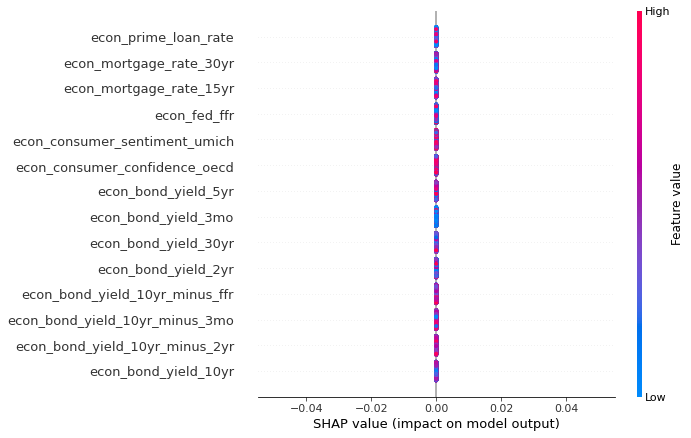

In [26]:
'''
Documentation and tutorials: 
	- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models.html
	- https://github.com/slundberg/shap 
	- https://analyticsindiamag.com/a-complete-guide-to-shap-shapley-additive-explanations-for-practitioners/
'''

explainer = shap.TreeExplainer(estimator) 
shap_values = explainer(df_features) 

# Visualise the feature weight and important for the entire rows. 
shap.plots.beeswarm(shap_values, max_display=20) 

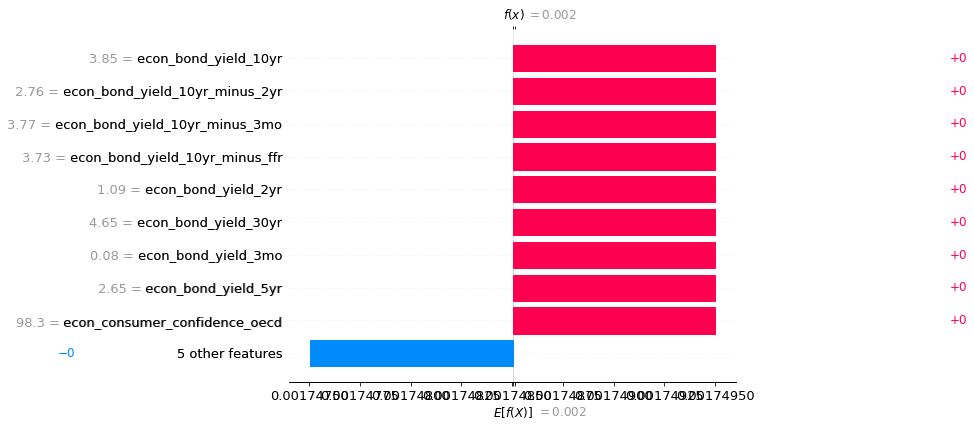

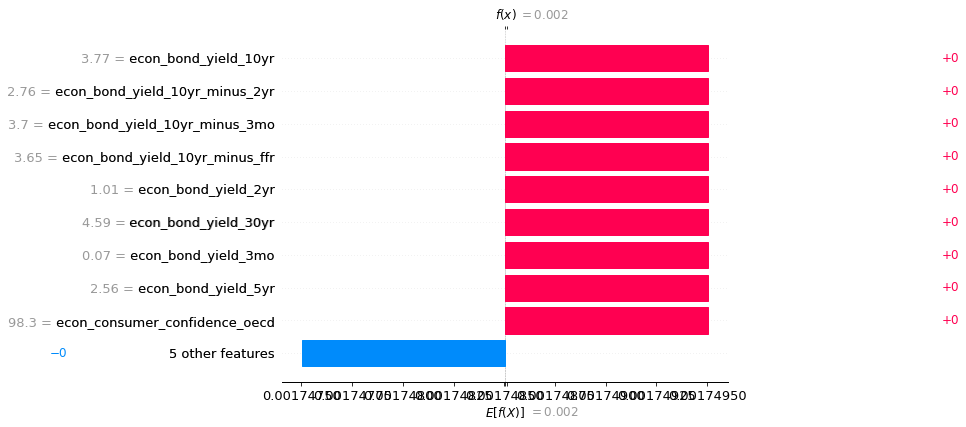

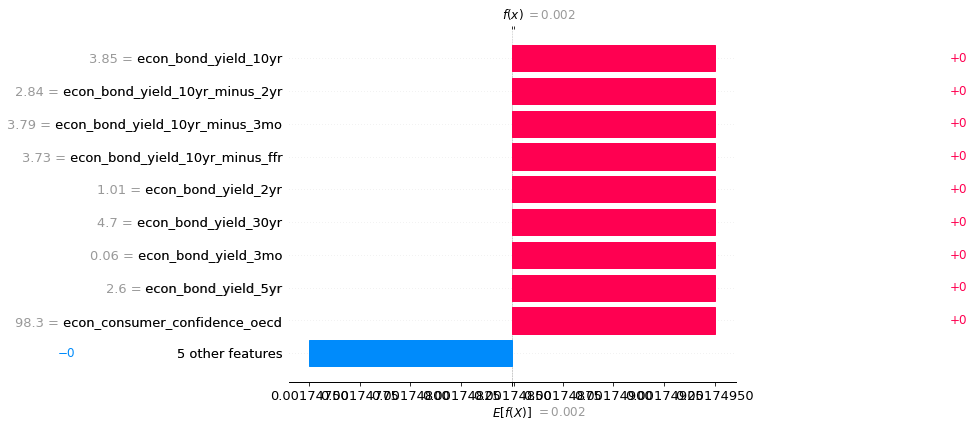

In [27]:
# SHAP. Visualise the feature weight for a single row. 
shap.plots.waterfall(shap_values[0]) 
shap.plots.waterfall(shap_values[1]) 
shap.plots.waterfall(shap_values[2]) 

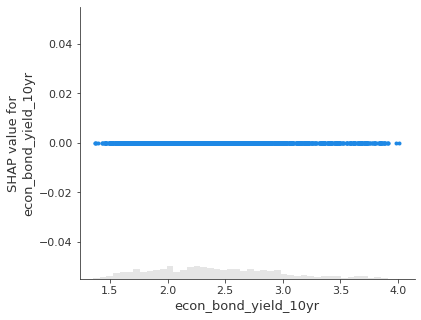

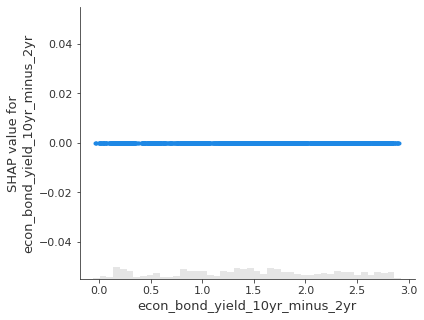

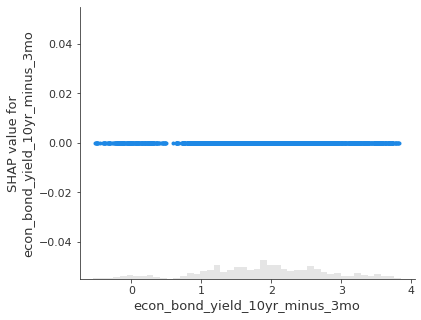

In [28]:
# SHAP. Visualise the feature weight trend for each feature. 
shap.plots.scatter(shap_values[:,0]) 
shap.plots.scatter(shap_values[:,1]) 
shap.plots.scatter(shap_values[:,2]) 

### Save the model. 

In [29]:
# # Cache the model pipeline. 
# mlpipe_name = "mlpipe_estim" 
# manage_files.save_version_pk(dirpath=DIR_MLMODEL_MLESTIM, obj_name=mlpipe_name, object=mlpipe_estim) 
# mlpipe_estim_loaded = manage_files.load_version_pk(dirpath=DIR_MLMODEL_MLESTIM, obj_name=mlpipe_name, version_load="latest") 